In [1]:
import time
import json

import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, accuracy_score, plot_confusion_matrix, f1_score
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV

import stellargraph as sg
from stellargraph import datasets
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    Node2VecNodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE, Dense

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
import utils

n = 10000
v_sets, e_sets, core_targets, ext_targets, v_sample, e_sample = utils.load_for_jupyter(n)

Dataset already downloaded. Loading it from file system
LOADING DATA: 1.00 s
SUBSAMPLING: 0.05 s
PREPROCESSING: 0.05 s


In [3]:
batch_size = 300
epochs = 15
# Use 70% of edges for training, the rest for testing:
train_size = 0.7
test_size = 0.3

In [4]:
# Initialize SG graph
G = sg.StellarDiGraph(v_sets, e_sets)

In [5]:
nodes_with_labels = v_sets.copy()

In [6]:
ext_targets.size

2744

In [7]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 19006, Edges: 10000

 Node types:
  Account: [10946]
    Features: float32 vector, length 3
    Edge types: Account-money transfer->Account, Account-money transfer->Derived Entity
  Customer: [3423]
    Features: float32 vector, length 5
    Edge types: Customer-has account->Account, Customer-has address->Address, Customer-is similar->External Entity
  Derived Entity: [3028]
    Features: float32 vector, length 4
    Edge types: Derived Entity-is similar->External Entity, Derived Entity-money transfer->Account
  External Entity: [1182]
    Features: float32 vector, length 4
    Edge types: none
  Address: [427]
    Features: float32 vector, length 2
    Edge types: none

 Edge types:
    Account-money transfer->Account: [3236]
        Weights: range=[1, 500], mean=182.574, std=224.655
        Features: none
    Customer-has account->Account: [2990]
        Weights: all 1 (default)
        Features: none
    Derived Entity-money transfer->Acco

In [8]:
# Split edges into train and test sets

train_ID, test_ID = model_selection.train_test_split(
    ext_targets, train_size=train_size, test_size=test_size, #stratify=ext_targets
)

In [9]:
# Select only nodes of type "Account" for prediction

train_ID = train_ID[train_ID.index.isin(v_sets['Account'].index)]
test_ID = test_ID[test_ID.index.isin(v_sets['Account'].index)]

In [10]:
# Convert targets labels in one-hot encoded features (optional, for categorical targets)

target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train_ID)
test_targets = target_encoding.transform(test_ID)

In [11]:
train_ID.shape

(892, 1)

In [12]:
train_targets.shape

(892, 659)

In [13]:
# Choosing a 2 layer model with 8 nodes sampled in the first layer and 4 in the second.
num_samples = [8, 4]
# we can do 8*4 = 32x32 hidden layer size, since len(num_samples) defines 
# the number of hops (layers) in the HinSAGE model

In [14]:
'''
HinSAGENodeGenerator(G, batch_size, num_samples, head_node_type=None, schema=None, seed=None, name=None)

G = graph
batch_size = size of batch to return
num_samples = the number of samples per layer (hop) to take
head_node_type = the node type that will be given to the generator using the flow method. 
                  The model will expect this type.
                  If not given, it defaults to a single node type.
'''

generator = HinSAGENodeGenerator(
    G, 
    batch_size, 
    num_samples,
    head_node_type="Account"
)

In [15]:
# Flow

train_gen = generator.flow(train_ID.index, train_targets, shuffle=True)
test_gen = generator.flow(test_ID.index, test_targets)

In [16]:
generator.schema.schema

{'Derived Entity': [EdgeType(n1='Derived Entity', rel='is similar', n2='External Entity'),
  EdgeType(n1='Derived Entity', rel='money transfer', n2='Account')],
 'External Entity': [],
 'Address': [],
 'Account': [EdgeType(n1='Account', rel='money transfer', n2='Account'),
  EdgeType(n1='Account', rel='money transfer', n2='Derived Entity')],
 'Customer': [EdgeType(n1='Customer', rel='has account', n2='Account'),
  EdgeType(n1='Customer', rel='has address', n2='Address'),
  EdgeType(n1='Customer', rel='is similar', n2='External Entity')]}

In [17]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

In [18]:
# Dropout
# (must be tuned)

dropout = 0.5

In [19]:
hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes,
    activations=['relu', 'softmax'],
    generator=generator, 
    bias=True,
    normalize="l2",
    dropout=dropout
)

In [20]:
x_inp, x_out = hinsage.in_out_tensors()

In [21]:
def run_deep_graph_infomax(base_model, generator, epochs):
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes(node_type="Account"))
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    # Train
    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    es = EarlyStopping(monitor="loss", min_delta=0, patience=15)
    history = model.fit(gen, epochs=epochs, verbose=1, callbacks=[es])
    sg.utils.plot_history(history)

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    # for full batch models, squeeze out the batch dim (which is 1)
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    #do TSNE here
    return x_emb_in, x_emb_out, model


Epoch 1/15
37/37 [==============================] - 8s 214ms/step - loss: 0.6323
Epoch 2/15
37/37 [==============================] - 8s 213ms/step - loss: 0.5457
Epoch 3/15
37/37 [==============================] - 8s 217ms/step - loss: 0.4981 1s - loss: 
Epoch 4/15
37/37 [==============================] - 8s 211ms/step - loss: 0.4625 5s - l - ETA
Epoch 5/15
37/37 [==============================] - 8s 214ms/step - loss: 0.4479
Epoch 6/15
37/37 [==============================] - 8s 208ms/step - loss: 0.4380
Epoch 7/15
37/37 [==============================] - 8s 215ms/step - loss: 0.4252
Epoch 8/15
37/37 [==============================] - 8s 215ms/step - loss: 0.4219
Epoch 9/15
37/37 [==============================] - 8s 218ms/step - loss: 0.4091
Epoch 10/15
37/37 [==============================] - 8s 211ms/step - loss: 0.4025
Epoch 11/15
37/37 [==============================] - 8s 217ms/step - loss: 0.3975
Epoch 12/15
37/37 [==============================] - 8s 223ms/step - loss: 0.3794


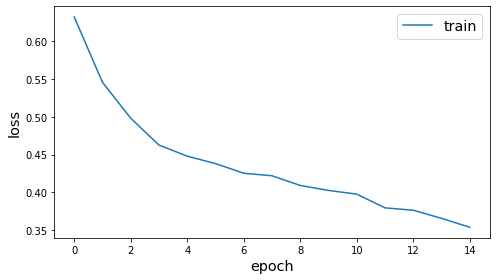

In [22]:
# Run Deep Graph Infomax

x_emb_in, x_emb_out, model = run_deep_graph_infomax(hinsage, generator, epochs=epochs)

In [23]:
emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)
all_embeddings = emb_model.predict(
    #use a heterogeneous generator...
    generator.flow(G.nodes(node_type="Account"))
)

In [24]:
embeddings_2d = pd.DataFrame(TSNE(n_components=2).fit_transform(all_embeddings), index=G.nodes(node_type="Account"))

In [25]:
embeddings_2d.head()

,0,1
1502000,-10.962629,-22.775438
15020010,6.930167,1.635135
15020011,-10.962629,-22.775438
15020034,-7.383170,-63.913559
15020036,20.948172,-20.591681


In [26]:
# draw the points
node_ids = G.nodes(node_type="Account").tolist()
ext_targets = v_sample.loc[[int(node_id) for node_id in node_ids]].ExtendedCaseGraphID 

label_map = {l: i*10 for i, l in enumerate(np.unique(ext_targets), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in ext_targets]

In [27]:
len(node_ids)

10946

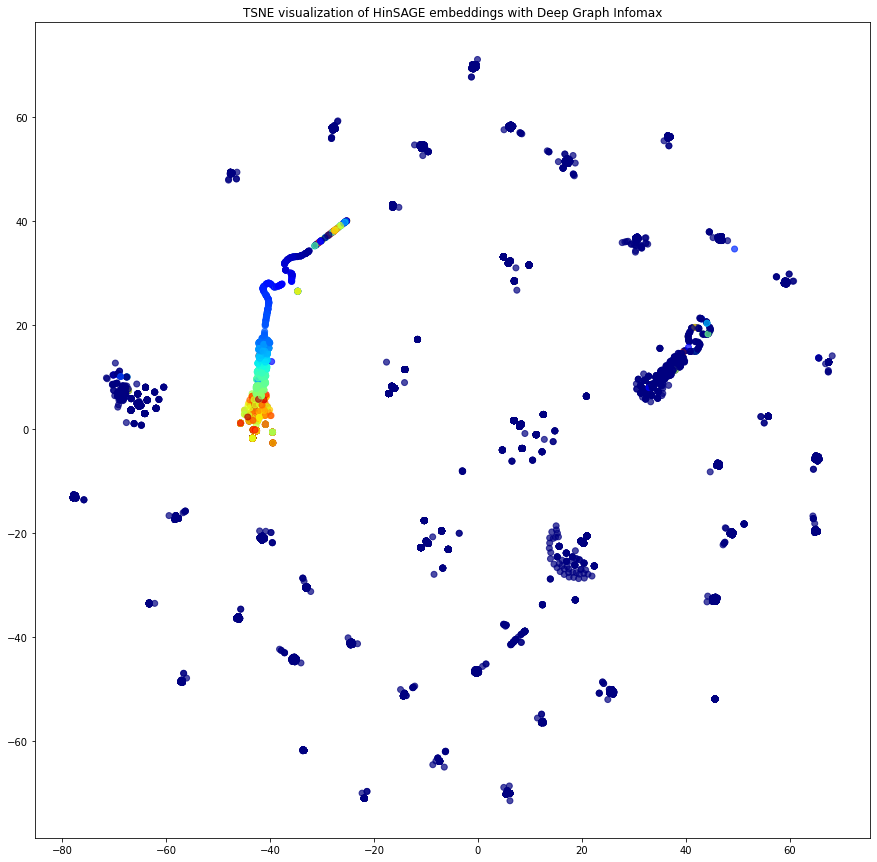

In [28]:
alpha = 0.7


fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    embeddings_2d[0],
    embeddings_2d[1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal")
plt.title("TSNE visualization of HinSAGE embeddings with Deep Graph Infomax")
plt.show()

In [29]:
all_embeddings.shape

(10946, 32)

In [30]:
node_ids_full = np.concatenate((
    G.nodes(node_type='Account'), 
    G.nodes(node_type='Customer'), 
    G.nodes(node_type='Derived Entity')
)).tolist()

In [31]:
len(node_ids_full)

17397

In [32]:
len(np.concatenate((
    all_embeddings,
    all_embeddings
)))
#Perfect

21892

In [33]:
# Now: classification time!

In [34]:
# Split in train(70%), test(15%) and validation set (15%)
train_ID, test_ID = model_selection.train_test_split(
ext_targets, train_size=0.7, test_size=None, #stratify=ext_targets
)
val_ID, test_ID = model_selection.train_test_split(
test_ID, train_size=0.5, test_size=None, #stratify=test_ID
)
print("train/val/test: ",len(train_ID.index),len(val_ID.index),len(test_ID.index))

train/val/test:  7662 1642 1642


In [35]:
# Convert targets labels in one-hot encoded features (optional, for categorical targets)
target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train_ID)
val_targets = target_encoding.transform(val_ID)
test_targets = target_encoding.transform(test_ID)

In [36]:
# Another approach

In [37]:
X = all_embeddings
y = np.array(ext_targets)

In [38]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.3, test_size=None)

In [39]:
print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (3283, 32)
 y_train = (3283,)
 X_test = (7663, 32)
 y_test = (7663,)


In [41]:
clf = LogisticRegressionCV(
    Cs=4000, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300
)
clf.fit(X_train, y_train)

/Users/nicolasracchi/.local/share/virtualenvs/hpc_2020-u8KpsjyS/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/nicolasracchi/.local/share/virtualenvs/hpc_2020-u8KpsjyS/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nicolasracchi/.local/share/virtualenvs/hpc_2020-u8KpsjyS/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarnin

KeyboardInterrupt: 

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
f1_score(y_test, y_pred, average='weighted')

In [ ]:
len(y_pred)

In [ ]:
equal = 0
notzero_pred = 0
notzero_test = 0
for i in range(len(y_pred)):
    if y_pred[i] != 0.0:
        notzero_pred += 1
    if y_test[i] != 0.0:
        notzero_test += 1
    if y_pred[i] == y_test[i]:
        equal += 1

In [ ]:
notzero_pred

In [ ]:
notzero_test

In [ ]:
X_test[0]

In [ ]:
y_test[0]

In [ ]:
# TO TEST: CLASSIFICATION::
def run_classify(x_emb_in, x_emb_out, train_ID, test_ID):
    #train_subjects, test_subjects = model_selection.train_test_split(
    #    subjects, train_size=0.1, test_size=None)
    
    train_subjects = train_ID
    test_subjects = test_ID
    
    emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)

    test_gen = generator.flow(test_subjects.index)
    train_gen = generator.flow(train_subjects.index)

    test_embeddings = emb_model.predict(test_gen)
    train_embeddings = emb_model.predict(train_gen)

    # some generators yield predictions in a different order to the .flow argument,
    # so we need to get everything lined up correctly
    #ordered_test_subjects = reorder(test_gen, test_subjects)
    #ordered_train_subjects = reorder(train_gen, train_subjects)

    lr = LogisticRegression(multi_class="auto", solver="lbfgs")
    lr.fit(train_embeddings, ordered_train_subjects)

    y_pred = lr.predict(test_embeddings)
    acc = (y_pred == ordered_test_subjects).mean()

    return acc, x_emb_out